In [1]:
from numbers_parser import Document
import pandas as pd
import glob,os
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
from scipy.optimize import minimize,root_scalar

/Users/manuel/miniconda3/lib/python3.9/site-packages/numbers_parser/__init__.py:68: UserWarning: Numbers version 13.1 not tested with this version


In [17]:
class Energy:
    def __init__(self,production_params=None,usage_params=None,last_d=None) -> None:
        if production_params is None:
            self.production_params = np.array([5,30, 10])
        else:
            self.production_params=production_params

        if usage_params is None:
            self.usage_params = np.array([20, -10, 15])
        else:
            self.usage_params=usage_params
        self.d0=datetime(2023,1,1)
        if last_d is None:
            self.last_d = self.d0+timedelta(days=1000)
        else:
            self.last_d=last_d


    def load_meter(self,file):
        doc = Document(file)
        sheets = doc.sheets()
        s = sheets['Electricity']
        data = s.tables['Inputs'].rows(values_only=True)
        meter = pd.DataFrame(data[1:], columns=data[0])[['Date ', 'Meter']]
        meter = meter.rename(columns={x:x.lower().replace(' ','') for x in meter.columns})
        meter['date']=[x.replace(tzinfo=None) for x in meter['date']]
        meter['from']=meter['date'].shift(1)
        meter['to']=meter['date']
        meter['net_used'] = meter['meter'].diff(1)
        meter['dt']=(meter['to']-meter['from'])/timedelta(days=1)
        meter = meter.dropna()
        meter['t0']=(meter['from']-self.d0)/timedelta(days=1)
        meter['t1']=(meter['to']-self.d0)/timedelta(days=1)
        #meter['net_cum_used'] = meter['net_used'].cumsum()

        
        self.meter_df = meter
        return self
    
    def compute_total_used(self):
        x_interp=np.concatenate([[self.produced_df['t1'].values.min()-1],self.produced_df['t1'].values])
        y_interp = np.concatenate([[0],self.produced_df['cum_produced'].values])
        f_cum_prod = interp1d(x_interp,y_interp,bounds_error=False)
        self.meter_df['produced']=f_cum_prod(self.meter_df['t1'].values)-f_cum_prod(self.meter_df['t0'].values)
        self.meter_df['used']=self.meter_df['produced']+self.meter_df['net_used']
        tot_prod = self.meter_df['produced'].sum()
        ind = self.meter_df['used']<0
        corr=np.zeros(self.meter_df.shape[0])
        corr[ind] = -self.meter_df['used'].values[ind]

        eta = (tot_prod-corr.sum()-np.nansum(self.meter_df['produced'].values[ind]))/np.nansum(self.meter_df['produced'].values[~ind])

        corr[~ind] = (eta-1)*self.meter_df['produced'].values[~ind]
        self.meter_df['corr']=corr
        self.meter_df['produced']+=corr
        self.meter_df['used']=self.meter_df['produced']+self.meter_df['net_used']

        return self


    
    def load_produced(self,file):
        produced = pd.read_csv(file).rename(columns={'Date/Time':'Date','Energy Produced (Wh)':'Produced'})
        produced=produced.head(produced.shape[0]-1)
        produced['Date']=pd.to_datetime(produced['Date'])
        produced=produced.rename(columns={'Date':'from','Produced':'produced'})
        produced['to'] = produced['from']+pd.Timedelta(days=1)-pd.Timedelta(seconds=1)
        produced=produced[['from','to','produced']]
        produced['produced']=[float(x.replace(',',''))/1000 for x in produced['produced'].values]
        produced['cum_produced'] = produced['produced'].values.cumsum()
        produced=produced.loc[produced['cum_produced']>0]
        produced['t0']=(produced['from']-self.d0)/timedelta(days=1)
        produced['t1']=(produced['to']-self.d0)/timedelta(days=1)
        
        self.produced_df = produced
        return self
    
    def production(self,d,params=None):
        if params is None:
            params = self.production_params
        
        a=params[0]
        b=params[1]
        c=params[2]
        return a+b*np.sin(np.pi*(d-c)/365)**2

    def cum_production(self,d,params=None):
        xx = np.arange(365)+1
        prod = self.production(xx,params=params)
        xx=np.concatenate([[0],xx])
        yy=np.concatenate([[0],prod.cumsum()])
        return interp1d(xx,yy)(d)

    def fit_production(self):
        fitting_set = self.produced_df.copy()
        ind = fitting_set['from']<=self.last_d
        fitting_set=fitting_set.loc[ind]
        day_of_year=(fitting_set['from']-fitting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        f_tar = lambda params: np.sum((self.production(day_of_year,params=params)-fitting_set['produced'].values)**2)
        sol = minimize(f_tar,self.production_params,bounds=((0,1000),(0,1000),(0,365)))
        self.production_params=sol.x
        return self
    
    def plot_production(self,ax=None):
        plotting_set = self.produced_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        if ax is None:
            fig,ax = plt.subplots(1,2,figsize=(10,5))

        ax[0].plot(day_of_year,plotting_set['produced'],'.')
        x = np.arange(365)+1
        ax[0].plot(x,self.production(x))
        ax[1].plot(day_of_year,plotting_set['produced'].cumsum(),'.')
        ax[1].plot(x,self.cum_production(x))

        produced = plotting_set['produced'].sum()
        produced_eoy = self.cum_production(365)
        title=f'Produced {produced:0.0f}, EOY = {produced_eoy:0.0f}'
        ax[1].set_title(title)
        
        for ax_ in np.ravel([ax]):
            ax_.grid(True)

    def usage(self,d,params=None):
        if params is None:
            params = self.usage_params
        
        a=params[0]
        b=params[1]
        c=params[2]
        #c=0
        return a+b*np.sin(np.pi*(d-c)/365)**2

    def cum_usage(self,d,params=None):
        xx = np.arange(365)+1
        usage = self.usage(xx,params=params)
        xx=np.concatenate([[0],xx])
        yy=np.concatenate([[0],usage.cumsum()])
        
        return interp1d(xx,yy)(d)



    def fit_use(self):
        fitting_set = self.meter_df.copy()
        ind = fitting_set['date']<=self.last_d
        fitting_set=fitting_set.loc[ind]
        
        fitting_set=fitting_set.dropna()
        
        day_of_year0=(fitting_set['from']-fitting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year0=day_of_year0.values

        day_of_year1=(fitting_set['to']-fitting_set['to'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year1=day_of_year1.values
        
        
        f_tar = lambda params: np.sum(((self.cum_usage(day_of_year1,params=params)-self.cum_usage(day_of_year0,params=params) - fitting_set['used'])/(day_of_year1-day_of_year0))**2)
        sol = minimize(f_tar,self.usage_params,bounds=((0,100),(-100,100),(0,365)))
        self.usage_params=sol.x
        return self
    
    def plot_usage(self,ax=None):
        plotting_set = self.meter_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        if ax is None:
            plt.figure()
            ax=plt.gca()
        ax.plot(day_of_year,plotting_set['used'].cumsum(),'.')
        x=np.arange(365)+1
        ax.plot(x,self.cum_usage(x))
        used=plotting_set['used'].sum()
        used_eoy = self.cum_usage(365)
        title=f'Used {used:0.0f}, EOY = {used_eoy:0.0f}'
        ax.set_title(title)
        ax.grid(True)
    
    def plot(self):
        markersize=1
        
        fig,ax=plt.subplots(1,2,figsize=(20,8))
        plotting_set = self.produced_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]

        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values
        produced = plotting_set['produced'].sum()
        produced_eoy = self.cum_production(365)

        #ax[0].plot(day_of_year,plotting_set['produced'],'.')
        x = day_of_year
        #ax[0].plot(x,self.production(x))
        ax[0].plot(self.production(x),plotting_set['produced'],'.',label='produced')
        ax[1].plot(day_of_year,plotting_set['produced'].cumsum(),'.',label=f'Produced {produced:0.0f}',color='C0',markersize=markersize)
        x=np.arange(365)+1
        ax[1].plot(x,self.cum_production(x),label=f' Produced EOY {produced_eoy:0.0f}',color='C0')

        t0=(datetime.now()-self.d0)/timedelta(days=1)

        plotting_set = self.meter_df.copy()
        year = plotting_set['from'].max().year
        ind = plotting_set['from'].apply(lambda x: x.year == year)
        plotting_set = plotting_set.loc[ind]
        day_of_year=(plotting_set['from']-plotting_set['from'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year=day_of_year.values

        day_of_year1=(plotting_set['to']-plotting_set['to'].apply(lambda x: datetime(x.year,1,1)))/timedelta(days=1)
        day_of_year1=day_of_year1.values
        ax[0].plot((self.cum_usage(day_of_year1)-self.cum_usage(day_of_year))/(day_of_year1-day_of_year),plotting_set['used']/(day_of_year1-day_of_year),'.',label='usage')
        xx = ax[0].get_xlim()
        ax[0].plot(xx,xx)
        


        ax[1].axvline(x=t0)

        t1 = (self.last_d-self.d0)/timedelta(days=1)
        #print(t1)
        if t1<=365:
            ax[1].axvline(x=t1)
        used=plotting_set['used'].sum()
        used_eoy = self.cum_usage(365)
        
        ax[1].plot(day_of_year,plotting_set['used'].cumsum(),'.',label=f'Used {used:0.0f}',color='C1',markersize=markersize)
        
        ax[1].plot(x,self.cum_usage(x),label=f'Used EOY {used_eoy:0.0f}',color='C1')
        
        
        ax[1].plot(x,self.cum_usage(x)-self.cum_production(x),label=f'Net EOY {used_eoy-produced_eoy:0.0f}',color='C2')
        t=self.meter_df['t1'].values
        m0 = np.interp(0,t,self.meter_df['meter'].values)
        ax[1].plot(t,self.meter_df['meter']-m0,'.',markersize=markersize,color='C2')


        for ax_ in np.ravel([ax]):
            ax_.grid(True)
            ax_.legend()
        plt.savefig('plot.pdf')



'02-Jul'

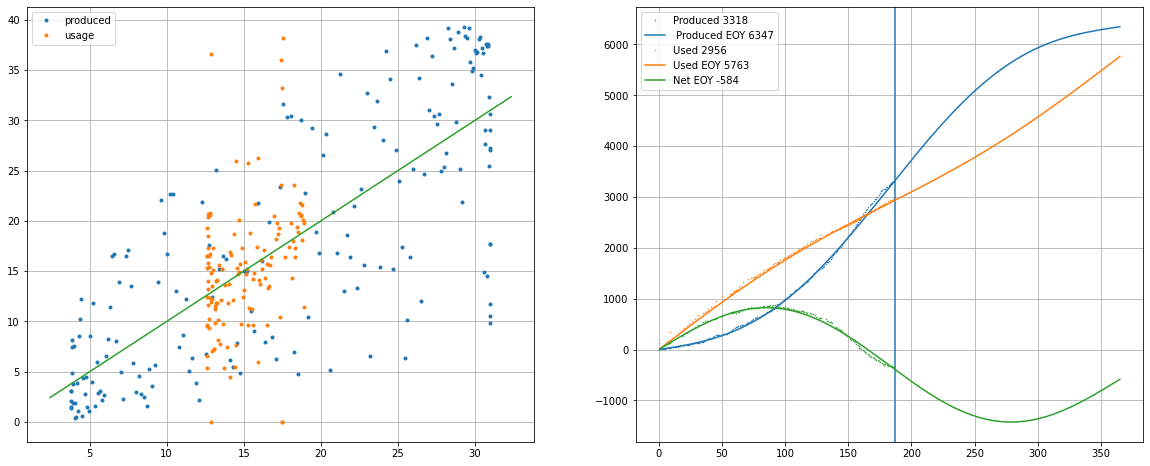

In [23]:

last_d = datetime(2023,7,1)
last_d=None
e=Energy(last_d=last_d)
folder = '/Users/manuel/Downloads/'

suffix = np.max([int(os.path.basename(x).replace('.csv','').split('_')[-1]) for x in glob.glob(os.path.join(folder,'3693411*.csv'))]).astype(str)
fn = os.path.join(folder,f'3693411_system_energy_20221218_to_{suffix}.csv')
e.load_produced(fn)
e.load_meter("/Users/manuel/OneDrive/Meterstanden.numbers")

e.produced_df
e.fit_production()
#e.plot_production()
e.compute_total_used()
e.fit_use()
#e.plot_usage()

e.plot()
(e.d0+timedelta(days=e.production_params[2]+365/2)).strftime('%d-%b')

In [3]:
e.meter_df

,date,meter,from,to,net_used,dt,t0,t1,produced,used,corr
1,2023-01-01 00:00:00,28781.0,2022-12-22 00:00:00,2023-01-01 00:00:00,161.0,10.000000,-10.000000,0.000000,20.004966,181.004966,-0.111049
2,2023-01-08 00:00:00,28896.0,2023-01-01 00:00:00,2023-01-08 00:00:00,115.0,7.000000,0.000000,7.000000,23.359390,138.359390,-0.129670
3,2023-01-10 00:00:00,28907.0,2023-01-08 00:00:00,2023-01-10 00:00:00,11.0,2.000000,7.000000,9.000000,11.959539,22.959539,-0.066388
4,2023-01-19 00:00:00,29052.0,2023-01-10 00:00:00,2023-01-19 00:00:00,145.0,9.000000,9.000000,18.000000,35.829228,180.829228,-0.198891
5,2023-01-20 00:00:00,29058.0,2023-01-19 00:00:00,2023-01-20 00:00:00,6.0,1.000000,18.000000,19.000000,12.134506,18.134506,-0.067360
...,...,...,...,...,...,...,...,...,...,...,...
125,2023-06-28 06:51:52,28488.0,2023-06-27 07:27:09,2023-06-28 06:51:52,-11.0,0.975498,177.310521,178.286019,20.428897,9.428897,-0.113402
126,2023-06-29 07:29:02,28492.0,2023-06-28 06:51:52,2023-06-29 07:29:02,4.0,1.025810,178.286019,179.311829,12.973455,16.973455,-0.072017
127,2023-06-30 07:57:07,28483.0,2023-06-29 07:29:02,2023-06-30 07:57:07,-9.0,1.019502,179.311829,180.331331,21.700024,12.700024,-0.120459
128,2023-07-01 08:21:23,28467.0,2023-06-30 07:57:07,2023-07-01 08:21:23,-16.0,1.016852,180.331331,181.348183,22.714417,6.714417,-0.126090


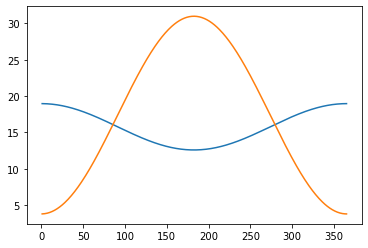

In [3]:
t=np.arange(1,366)
plt.plot(t,e.usage(t))
plt.plot(t,e.production(t))
e.produced_df['model']=e.production(e.produced_df['t1'])
#e.produced_df

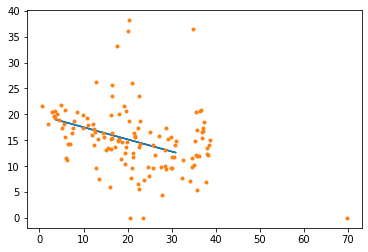

In [4]:
t=np.arange(1,366)
plt.plot(e.production(t),e.usage(t))
plt.plot(e.meter_df['produced']/e.meter_df['dt'],e.meter_df['used']/e.meter_df['dt'],'.')


In [49]:
df = pd.DataFrame()
df['From']=[datetime(2023,i,1) for i in range(1,13)]
df['To']=[datetime(2023,i,1) for i in range(2,13)] +[datetime(2024,1,1)]
df['t0'] = [(x-datetime(2023,1,1))/timedelta(days=1) for x in df['From']]
df['t1'] = [(x-datetime(2023,1,1))/timedelta(days=1) for x in df['To']]
df['Produced']=np.round(e.cum_production(df['t1'])-e.cum_production(df['t0'])).astype(int)
df['Estimate'] = np.array([154,251,522,735,783,767,765,682,520,342,168,121])
df['Produced_cum']=np.round(e.cum_production(df['t1'])).astype(int)
df['Estimate_cum'] = df['Estimate'].cumsum()
df['Used']=np.round(e.cum_usage(df['t1'])-e.cum_usage(df['t0'])).astype(int)
df['Used_cum']=np.round(e.cum_usage(df['t1'])).astype(int)
df['Used 2022']=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
df['Used 2022_cum']=df['Used 2022'].cumsum()
df

,From,To,t0,t1,Produced,Estimate,Produced_cum,Estimate_cum,Used,Used_cum,Used 2022,Used 2022_cum
0,2023-01-01,2023-02-01,0.0,31.0,138,154,138,154,583,583,548.66,548.66
1,2023-02-01,2023-03-01,31.0,59.0,220,251,358,405,504,1087,442.70,991.36
2,2023-03-01,2023-04-01,59.0,90.0,424,522,782,927,516,1603,451.32,1442.68
3,2023-04-01,2023-05-01,90.0,120.0,620,735,1402,1662,451,2054,395.07,1837.75
4,2023-05-01,2023-06-01,120.0,151.0,829,783,2231,2445,422,2476,389.44,2227.19
5,2023-06-01,2023-07-01,151.0,181.0,910,767,3141,3212,384,2859,362.98,2590.17
6,2023-07-01,2023-08-01,181.0,212.0,943,765,4083,3977,396,3255,371.58,2961.75
7,2023-08-01,2023-09-01,212.0,243.0,834,682,4918,4659,421,3676,344.19,3305.94
8,2023-09-01,2023-10-01,243.0,273.0,626,520,5544,5179,449,4125,330.73,3636.67
9,2023-10-01,2023-11-01,273.0,304.0,431,342,5975,5521,515,4640,386.67,4023.34


In [102]:
e.produced_df.loc[e.produced_df['from'].apply(lambda x: x.year==2023),'produced'].sum(),e.cum_production((datetime.today()-datetime(2023,1,1))/timedelta(days=1))

(3317.9719999999998, array(3337.4070883))

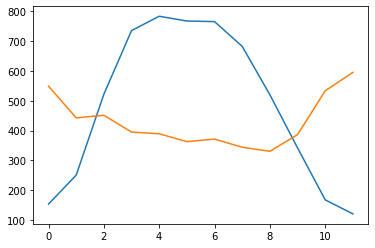

In [ ]:
estimate=np.array([154,251,522,735,783,767,765,682,520,342,168,121])
used_2022=np.array([548.66,442.7,451.32,395.07,389.44,362.98,371.58,344.19,330.73,386.67,533.32,595])
plt.plot(estimate)
plt.plot(used_2022)

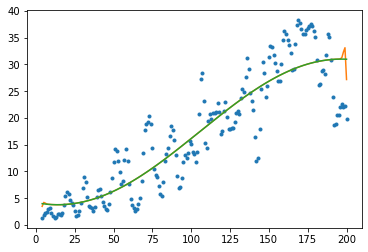

In [29]:
df = e.produced_df.copy()

d=df['from'].apply(lambda x: (x - datetime(x.year,1,1))/timedelta(days=1))
df['model']=e.production(d.values)
t=df['t0'].values
eta=1.5
w=np.exp(-((t[:,None]-t[None,:])/eta)**2)
w = w/w.sum(axis=0)

df['avg']=w@ df['produced']
df['model_avg']=w@ df['model']

plt.plot(df['avg'],'.')
plt.plot(df['model_avg'])
plt.plot(df['model'])